In [1]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, print_progress, read_mnist_data, add_variable_histogram_summaries, merge, interpolate
from os.path import exists
from glob import glob
import scipy

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


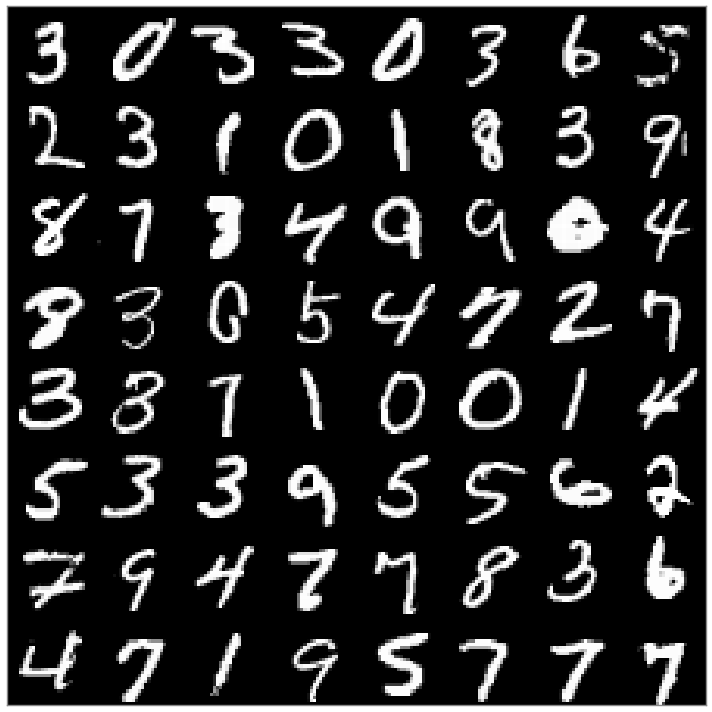

In [3]:
plot_images(merge(data.train.next_batch(64)[0]))

In [3]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [7]:
def generator(z, cat, cont, training):
    x_gen = tf.layers.dense(tf.concat([z, cat, cont], 1), 7 * 7 * 256, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    x_gen = tf.reshape(x_gen, (-1, 7, 7, 256))
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 128, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv1')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 64, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv2')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 32, (5, 5), (1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv3')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn4')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 1, (5, 5), (1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv4')
    return tf.nn.tanh(x_gen)

In [8]:
def discriminator(img, training):
    p = tf.layers.conv2d(img, 32, (5, 5), strides=(1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv1')
    p = lrelu(p, 0.2, 'lrelu1')
    
    p = tf.layers.conv2d(p, 64, (5, 5), strides=(1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv2')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    p = lrelu(p, 0.2, 'lrelu2')
    
    p = tf.layers.conv2d(p, 128, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv3')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    p = lrelu(p, 0.2, 'lrelu3')
    
    p = tf.layers.conv2d(p, 256, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv4')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    p = lrelu(p, 0.2, 'lrelu4')

    disc_out = tf.reshape(p, (-1, 7 * 7 * 256))
    p = tf.layers.dense(p, 1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    return p, disc_out

In [9]:
def Q(x, cont_dim):
    q = tf.layers.dense(x, 1024, activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    cat = tf.layers.dense(q, 10, activation=tf.nn.softmax, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc2')
    cont_mean = tf.layers.dense(q, cont_dim, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc3')
    cont_neg_ln_std = tf.layers.dense(q, cont_dim, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc4')
    return cat, cont_mean, cont_neg_ln_std

In [11]:
z_dim = 0
cont_dim = 32

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    training = tf.placeholder(tf.bool, name='training')
    x_image = tf.reshape(x, (-1, 28, 28, 1), 'x_image')
    cat = tf.placeholder(tf.float32, (None, 10), 'cat')
    cont = tf.placeholder(tf.float32, (None, cont_dim), 'cont')
    
with tf.variable_scope('generator'):
    x_gen = generator(z, cat, cont, training) 
    
with tf.variable_scope('discriminator'):
    l_x, _ = discriminator(x_image, training)
    tf.get_variable_scope().reuse_variables()
    l_g, disc_out = discriminator(x_gen, training)
    
with tf.variable_scope('Q'):
    q_cat, q_cont_mean, q_cont_neg_ln_std = Q(disc_out, cont_dim)
    
with tf.name_scope('optimizer'):
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.ones_like(l_g)))
    loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_x, labels=tf.ones_like(l_x))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.zeros_like(l_g)))
    loss_q_cat = -tf.reduce_mean(tf.reduce_sum(tf.log(q_cat + 1e-8) * cat, 1)) - tf.reduce_mean(tf.reduce_sum(tf.log(cat + 1e-8) * cat, 1))
    loss_q_cont = tf.reduce_mean(tf.reduce_sum(0.5 * (cont - q_cont_mean)**2 * tf.exp(q_cont_neg_ln_std) - 0.5 * q_cont_neg_ln_std, axis=1) + 0.5 * tf.log(2 * np.pi) * cont_dim)
    loss_q = loss_q_cat + 1e-1 * loss_q_cont
    optimizer_g = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_g = optimizer_g.compute_gradients(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimize_g = optimizer_g.apply_gradients(grads_g)
    optimizer_d = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_d = optimizer_d.compute_gradients(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))
    optimize_d = optimizer_d.apply_gradients(grads_d)
    optimize_q = tf.train.AdamOptimizer(2e-4, 0.5).minimize(loss_q, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Q') + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    
tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
tf.summary.scalar('loss_q_cat', loss_q_cat)
tf.summary.scalar('loss_q_cont', loss_q_cont)
add_variable_histogram_summaries()

for g_v_pair in grads_g:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
for g_v_pair in grads_d:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
summ = tf.summary.merge_all()

saver = tf.train.Saver()

INFO:tensorflow:Summary name generator/fc1/kernel:0 is illegal; using generator/fc1/kernel_0 instead.
INFO:tensorflow:Summary name generator/fc1/bias:0 is illegal; using generator/fc1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn1/beta:0 is illegal; using generator/bn1/beta_0 instead.
INFO:tensorflow:Summary name generator/bn1/gamma:0 is illegal; using generator/bn1/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv1/kernel:0 is illegal; using generator/tconv1/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv1/bias:0 is illegal; using generator/tconv1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn2/beta:0 is illegal; using generator/bn2/beta_0 instead.
INFO:tensorflow:Summary name generator/bn2/gamma:0 is illegal; using generator/bn2/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv2/kernel:0 is illegal; using generator/tconv2/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv2/bias:0 is illegal; using generator/tco

In [12]:
nb_name = 'InfoGAN-Saturated'
path_out = 'output/' + nb_name + '/'
path_chk = 'checkpoints/' + nb_name + '/' + nb_name
path_chk_data = 'checkpoints/' + nb_name + '/' + nb_name + '.data-00000-of-00001'
path_writer = 'checkpoints/' + nb_name

In [14]:
def plot_generated_images(sess, latent=None, label=None, cont_latent=None, save_name=None):
    if latent is None:
        if label is None:
            latent = np.random.uniform(-1, 1, (11, z_dim))
            labels = np.random.multinomial(1, [0.1]*10, len(latent))
        elif len(label) == 1:
            labels = np.zeros((11, 10))
            labels[range(11), label[0]] = 1
        else:
            labels = label
            latent = np.random.uniform(-1, 1, (len(label), z_dim))
    else:
        if label is None:
            labels = np.random.multinomial(1, [0.1]*10, len(latent))
        elif len(label) == 1:
            labels = np.zeros((len(latent), 10))
            labels[range(len(latent)), label[0]] = 1
        else:
            labels = label
            
    if cont_latent is None:
        cont_latent = np.random.uniform(-1, 1, (len(latent), cont_dim))
        
    generated_images = sess.run(x_gen, feed_dict={cat: labels, z: latent, cont: cont_latent, training:False})
    
    if label is None:
        plot_images((generated_images + 1) / 2, np.argmax(labels, 1))
    else:
        plot_images(merge((generated_images + 1) / 2))
    
    if save_name is not None:
        scipy.misc.imsave(path_out + save_name + '.jpg', merge((generated_images + 1) / 2)[0, :, :, 0])

In [15]:
batch_size = 64
plots_per_epoch = 3

batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter(path_writer, tf.get_default_graph())
    
    with tf.Session(config=config) as sess:
        if exists(path_chk_data):
            saver.restore(sess, path_chk)
        else:
            sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            epoch_start_time = time()
            latent = np.random.uniform(-1, 1, (11, z_dim))
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                x_batch = x_batch / 0.5 - 1
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                cat_batch = np.random.multinomial(1, [0.1]*10, batch_size)
                cont_batch = np.random.uniform(-1, 1, (batch_size, cont_dim))
                feed_dict_train = {x: x_batch, cat: cat_batch, z: z_batch, cont: cont_batch, training: True}
                for _ in range(1):
                    sess.run(optimize_d, feed_dict_train)
                for _ in range(1):
                    sess.run(optimize_g, feed_dict_train)
                for _ in range(1):
                    sess.run(optimize_q, feed_dict_train)

                if (epoch * batches_per_epoch + batch) % 100 == 0:
                    writer.add_summary(sess.run(summ, feed_dict_train), global_step=epoch * batches_per_epoch + batch)
                    
                if batch % int(np.ceil(batches_per_epoch / plots_per_epoch)) == 0:
                    plot_generated_images(sess, latent)
                    
                print_progress(batch, batches_per_epoch, epoch_start_time)
                
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
            saver.save(sess, path_chk, write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))
    writer.close()

In [22]:
%mkdir $path_out

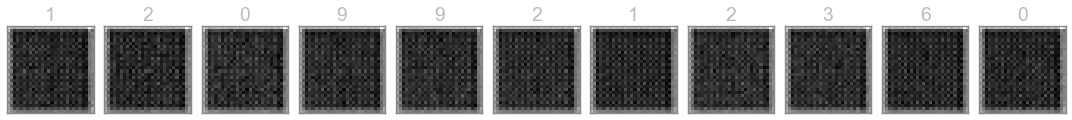

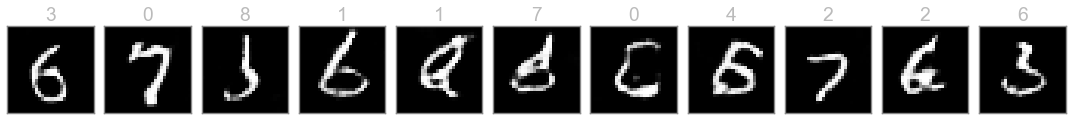

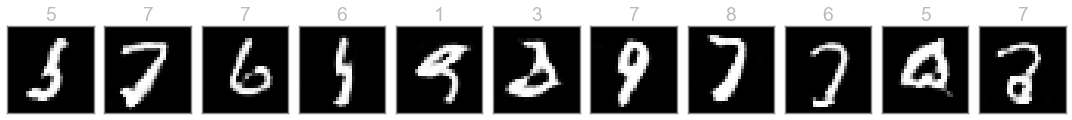

1 / 1 (100.0%)ted. Time - 92s, ETA - 0s


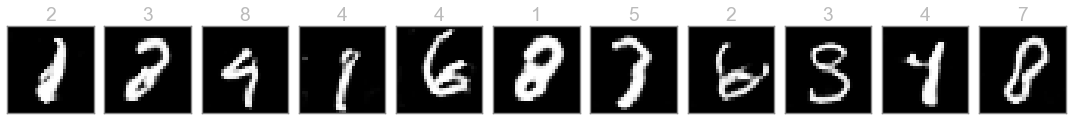

Time taken - 95.1s


In [16]:
optimize()

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Saturated/InfoGAN-Saturated


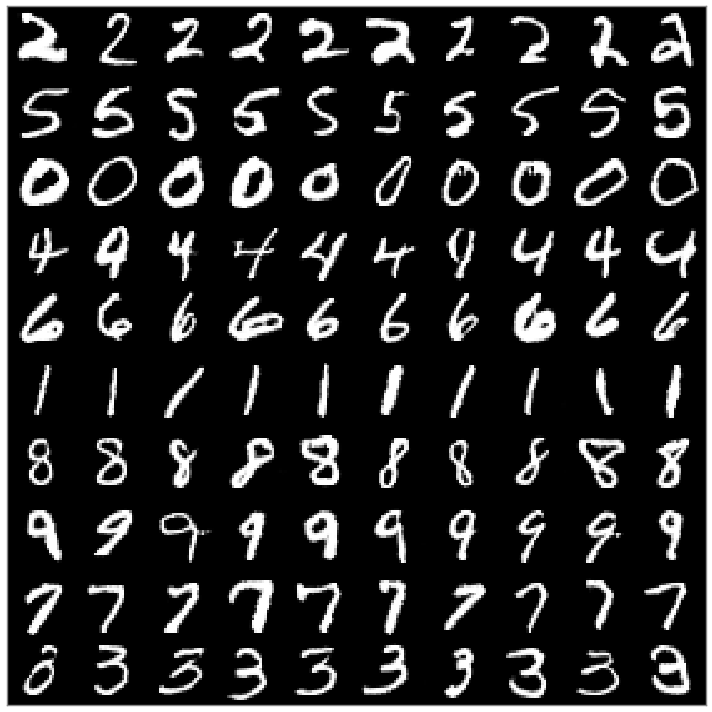

In [40]:
with tf.Session(config=config) as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
        
    latent = np.vstack([np.random.uniform(-1, 1, (10, z_dim))] * 10)
    labels = np.zeros((100, 10))
    for i in range(10):
        labels[i*10:i*10+10, i] = 1
        
    plot_generated_images(sess, latent, save_name='Cat-Sample')

In [17]:
with tf.Session(config=config) as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
        
    mean_cont_info = -sess.run(tf.reduce_mean(0.5 * (cont - q_cont_mean)**2 * tf.exp(q_cont_neg_ln_std) - 0.5 * q_cont_neg_ln_std, 0), {z: np.random.uniform(-1, 1, (1000, z_dim)), cont: np.random.uniform(-1, 1, (1000, cont_dim)), training:False})
    
    factors_order = mean_cont_info.argsort()[::-1]
    print(factors_order)

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Saturated/InfoGAN-Saturated
[1 6 0 4 8 5 9 2 7 3]


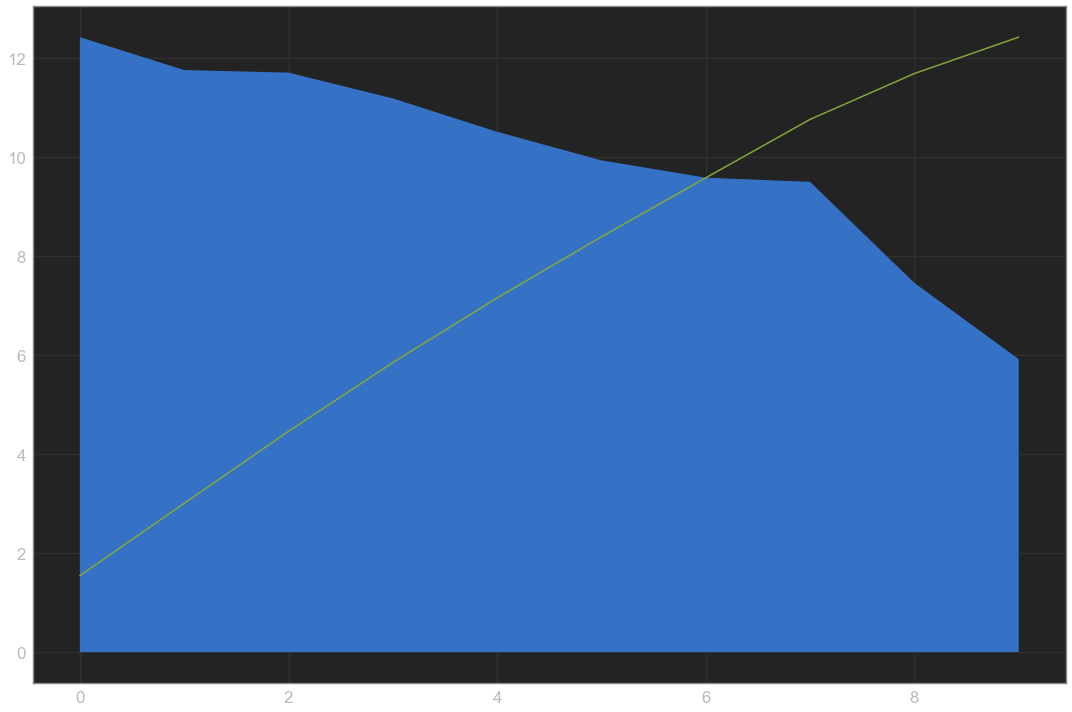

In [18]:
plt.fill_between(range(cont_dim), 0,  mean_cont_info[factors_order]/mean_cont_info.sum() * 100)
plt.plot(mean_cont_info[factors_order].cumsum()/mean_cont_info.sum() * mean_cont_info[factors_order][0]/mean_cont_info.sum() * 100, 'g')
plt.show()

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Saturated/InfoGAN-Saturated


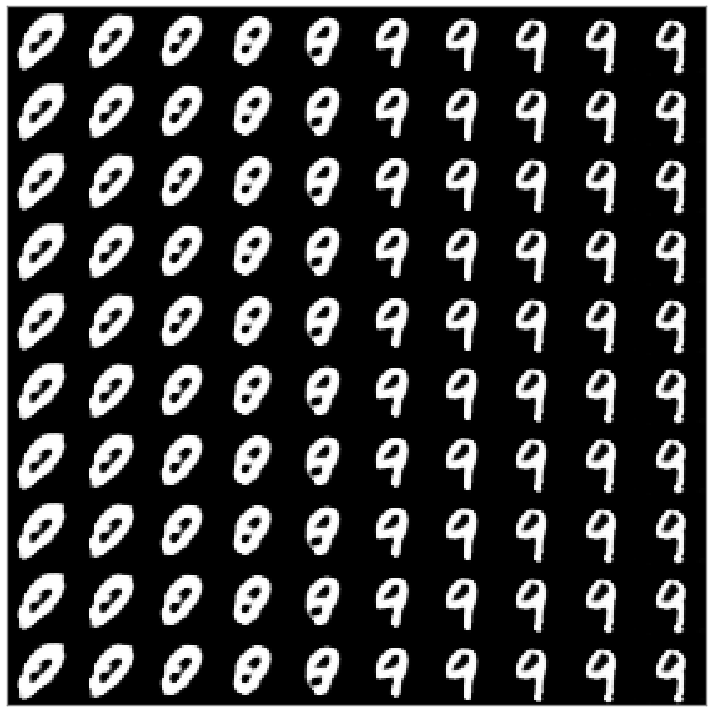

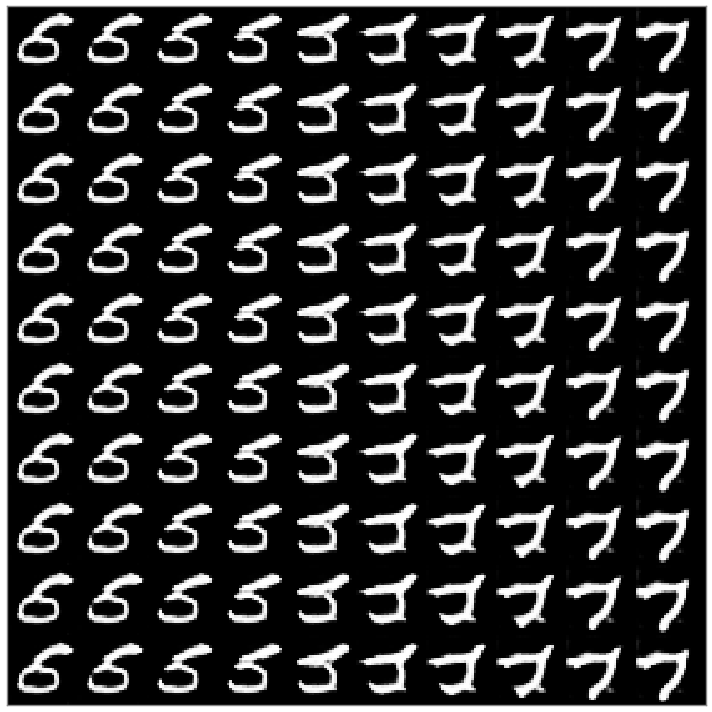

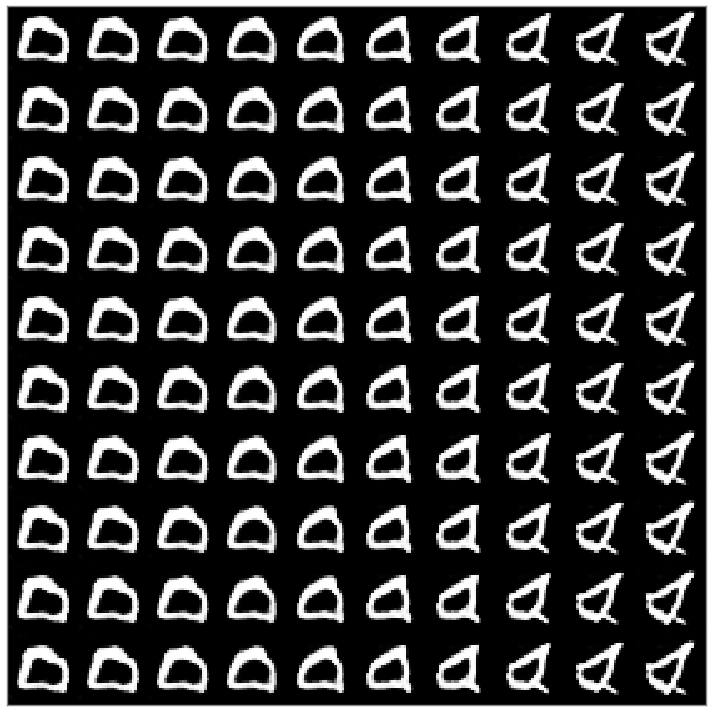

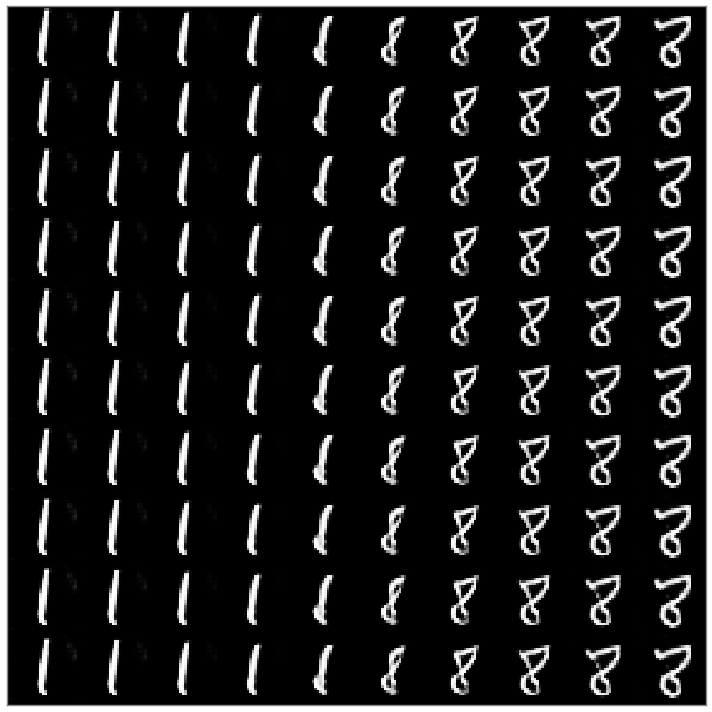

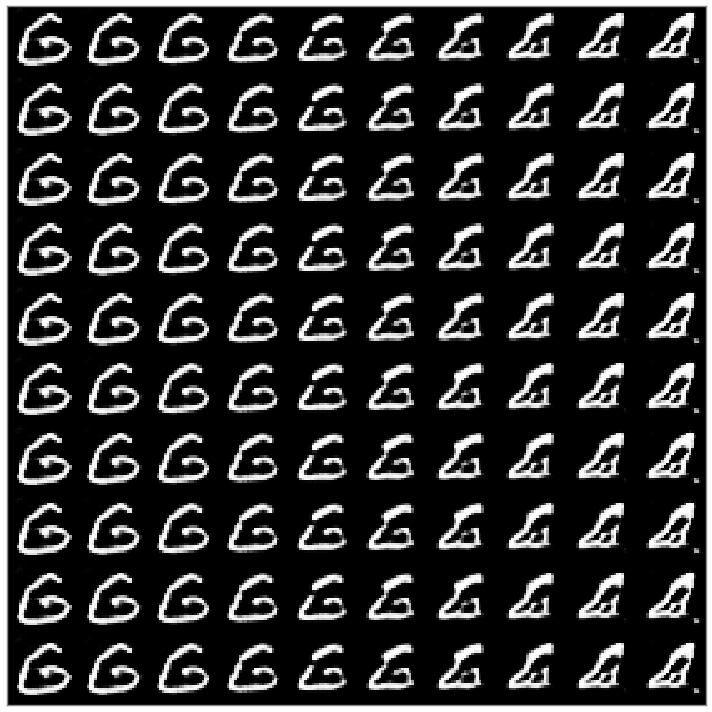

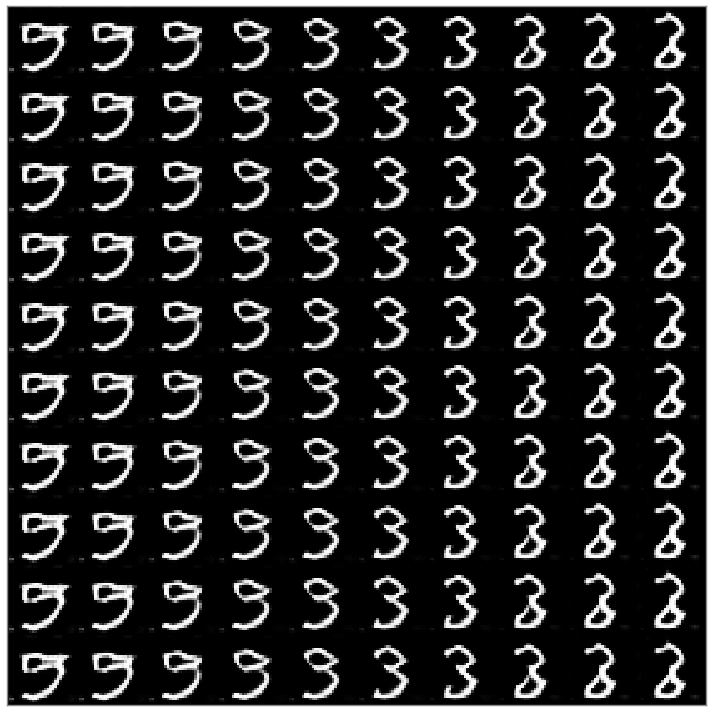

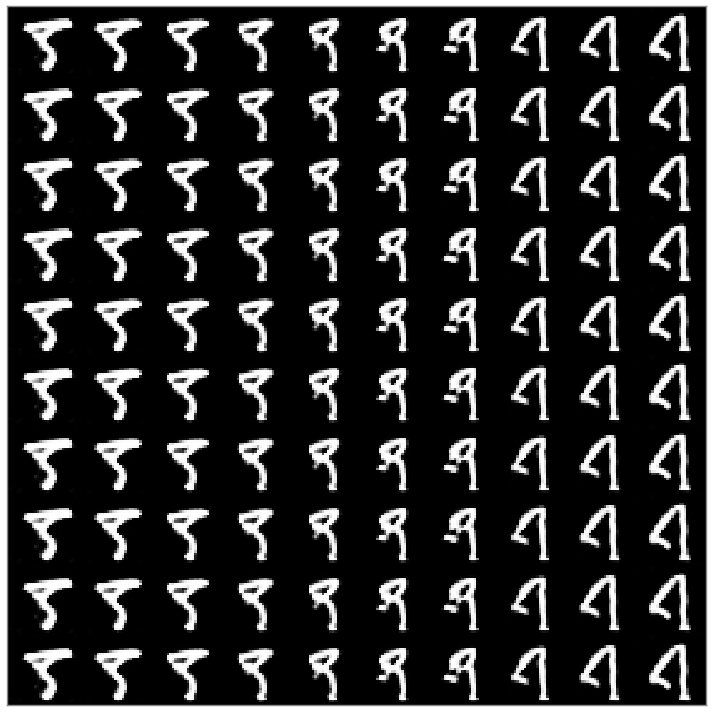

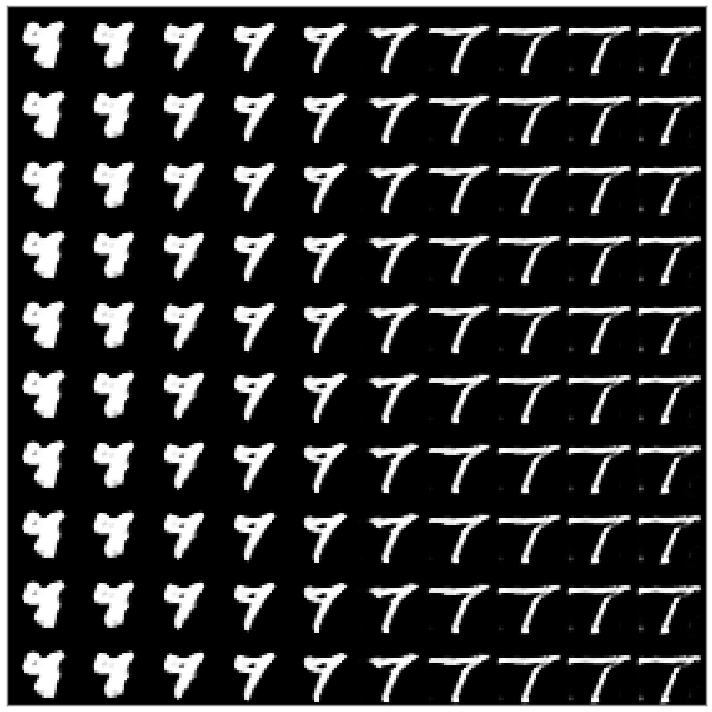

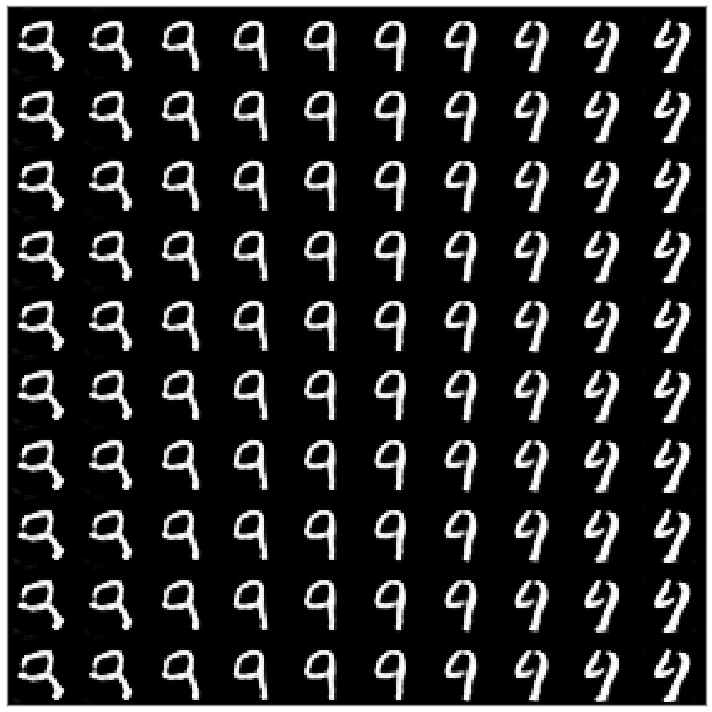

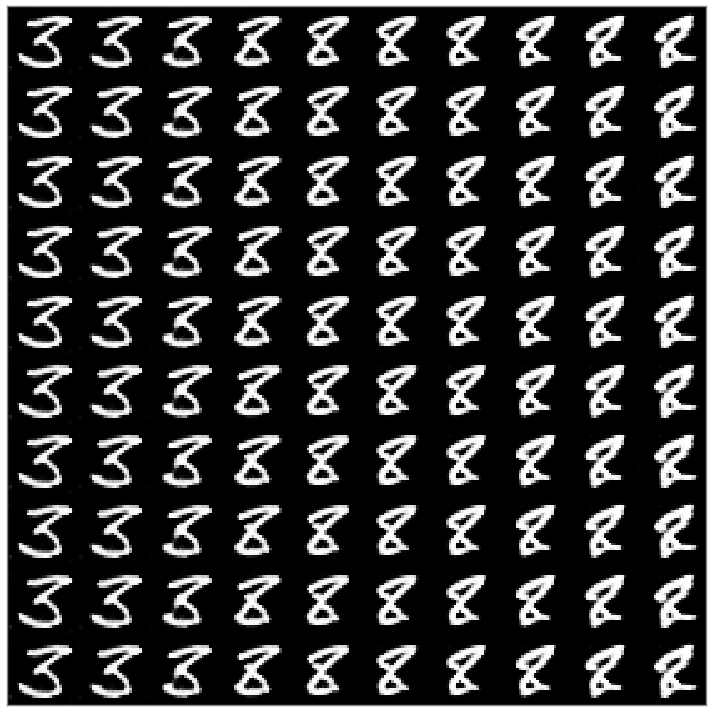

In [22]:
with tf.Session(config=config) as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
        
    for i in factors_order:
        latent = np.vstack([np.random.uniform(-1, 1, (1, z_dim))] * 100)
        labels = np.zeros((100, 10))
        for k in range(10):
            labels[k*10:k*10+10, k] = 1

        cont_latent = np.zeros((100, cont_dim))
        for j in range(cont_dim):
            cont_latent[:, j] = np.hstack([np.random.uniform(-1, 1, 1)] * 100)
        cont_latent[:, i] = np.hstack([np.linspace(-2, 2, 10)] * 10)
        
        plot_generated_images(sess, latent, labels, cont_latent)

In [25]:
import imageio
num_points = 300
numeral_order = [2, 5, 0, 9, 3, 1, 4, 8, 6, 7]

factor = np.linspace(-2, 2, num_points)

with tf.Session(config=config) as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
    
    image_stack = []
    for factor_val in factor:
        latent = np.vstack([np.random.uniform(-1, 1, (1, z_dim))] * 10 * cont_dim)
        
        labels = np.zeros((10, 10))
        labels[range(10), numeral_order] = 1
        labels = np.vstack([labels] * cont_dim)

        cont_latent = np.zeros((10 * cont_dim, cont_dim))
        for k in range(cont_dim):
            cont_latent[k*10:k*10+10, factors_order[k]] = factor_val

        generated_images = sess.run(x_gen, feed_dict={cat: labels, z: latent, cont: cont_latent, training:False})
        image_stack.append(merge(generated_images * 0.5 + 0.5, (cont_dim, 10)))
        
imageio.mimsave(path_out + 'Variation.gif', np.vstack(image_stack), fps=60)

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Saturated/InfoGAN-Saturated


/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Saturated/InfoGAN-Saturated


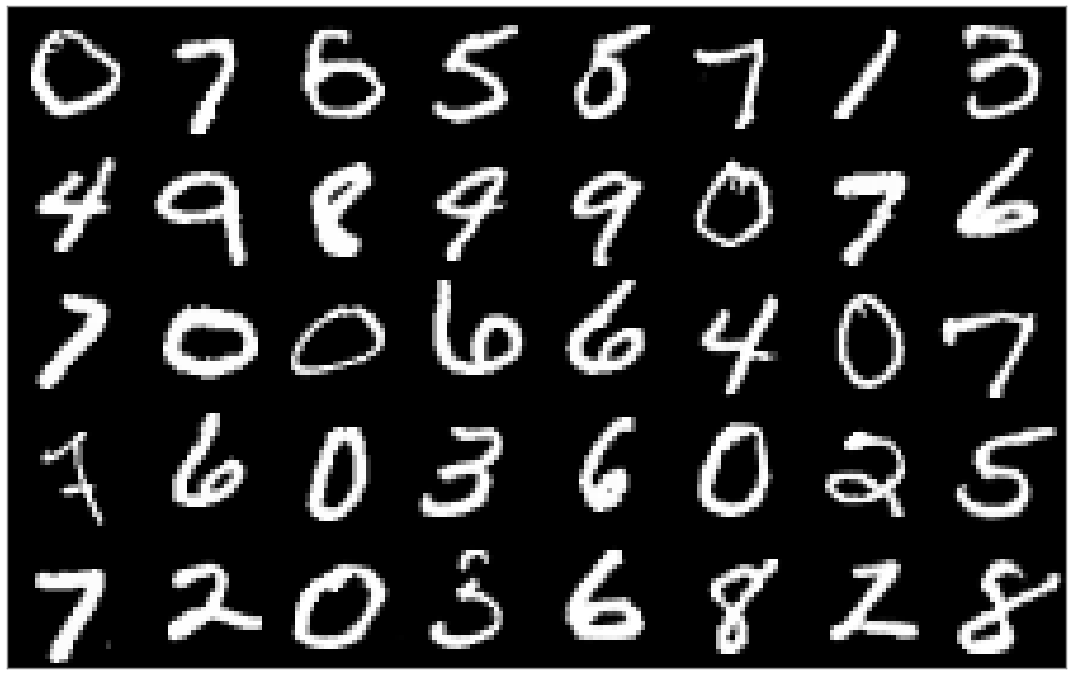

In [22]:
# Turing test
num_points = 40
frac_real = np.random.rand()

num_real = int(frac_real * num_points)
num_fake = num_points - num_real

def print_score(answers, real_answer_list):
    num_real = real_answer_list.count('r')
    num_fake = real_answer_list.count('f')
    num_points = num_real + num_fake
    if len(answers) != num_points:
        print("Answer length needs to be {}. Given {}.".format(num_points, len(answers)))
        return
    
    real_answer_list = list(joint_label[random_mix].flat)
    scores = np.zeros((num_points))
    errors = num_fake
    titles = [''] * num_points
    for i, answer in enumerate(answers):
        if answer == real_answer_list[i]:
            scores[i] = 1
            if answer == 'f':
                errors -= 1
            titles[i] = answer
        elif answer == 'f':
            titles[i] = "Blunder"
        else:
            titles[i] = "Forgery"

    plot_images(joint_data[random_mix], np.asarray(titles))
    print("Score: {}%\nError rate: {}%".format(int(scores.mean() * 100), int(errors / num_fake * 100)))
    
with tf.Session(config=config) as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
        
    #real_idx = np.load(path_out + 'Turing-real_idx.npy')
    real_idx = np.random.randint(0, data.test.num_examples, num_real)
    #np.save(path_out + 'Turing-real_idx.npy', real_idx)
    num_real = len(real_idx)
    real_data = data.test.images[real_idx].reshape(-1, 28, 28, 1)
    real_label = np.asarray(['r'] * num_real)
    #latent = np.load(path_out + 'Turing-Latent.npy')
    latent = np.random.uniform(-1, 1, (num_fake, z_dim))
    #np.save(path_out + 'Turing-Latent.npy', latent)
    num_fake = len(latent)
    
    cont_latent = np.random.uniform(-1, 1, (num_fake, cont_dim))
    latent_label = np.random.multinomial(1, [0.1]*10, num_fake)
        
    fake_data, disc_prob = sess.run([x_gen, tf.nn.sigmoid(l_g)], feed_dict={z: latent, cat: latent_label, cont: cont_latent, training:False})
    fake_label = np.asarray(['f'] * num_fake)
    joint_data = np.vstack([real_data, (fake_data + 1) / 2])
    joint_label = np.hstack([real_label, fake_label])
    
    #random_mix = np.load(path_out + 'Turing-random_mix.npy')
    random_mix = np.random.permutation(range(num_points))
    #np.save(path_out + 'Turing-random_mix.npy', random_mix)
    plot_images(merge(joint_data[random_mix]))
    scipy.misc.imsave(path_out + 'Turing.jpg', merge(joint_data[random_mix])[0, :, :, 0])

In [23]:
my_answers = 'frffffffffrfrffrffffrfrffffrrrfrfffrrrrf'

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Saturated/InfoGAN-Saturated

You human:


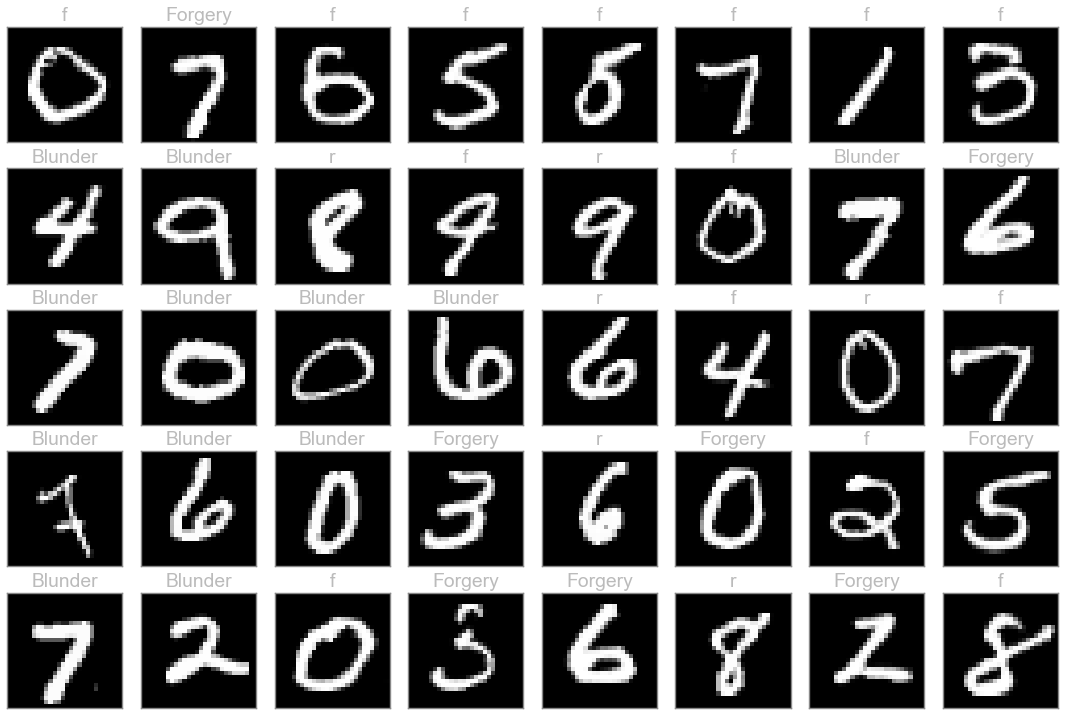

Score: 50%
Error rate: 36%


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [25]:
discriminator_answers = ''
with tf.Session(config=config) as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
        
    print("\nYou human:")
    print_score(my_answers, list(joint_label[random_mix]))

    real_probs, fake_probs = sess.run([tf.nn.sigmoid(l_x), tf.nn.sigmoid(l_g)], {x_image: real_data, x_gen: fake_data, training:False})
    joint_probs = np.vstack([real_probs, fake_probs])
    
    for prob in joint_probs[random_mix]:
        if prob >= 0.5:
            discriminator_answers += 'r'
        else:
            discriminator_answers += 'f'
            
print("\nDiscriminator:")
print_score(discriminator_answers, list(joint_label[random_mix]))